## Twitter trending topic analysis

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)



---
<a id="part1"></a>
## Part 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline


import re
import nltk
from bs4 import BeautifulSoup
import lxml
from textblob import TextBlob
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda,SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
from keras.layers.convolutional import Convolution1D
from keras import backend as K
from keras.layers.embeddings import Embedding

C:\Users\varsh\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Users\varsh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\varsh\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Data

In [2]:
data_xls = pd.read_excel('Data.xlsx', index_col=None)
data_xls.to_csv('data.csv', encoding='utf-8')
df = pd.read_csv('data.csv')

### Data Exploration

In [3]:
#df = pd.read_csv('train.csv')
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

(12881, 3)
   Unnamed: 0                                             Tweets  Category
0           0  USGS reports a M1.7 #earthquake 70km ESE of He...         1
1           1  QuakeFactor M 3.0, Southern Alaska: Sunday, Se...         1
2           2  What you wanna say abt #TTP #PeaceTalks &amp; ...         1
3           3  Top Story: Pakistan quake survivors face long ...         1
4           4  RT @SaimaMohsin: 264 dead, more than 400 injur...         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12881 entries, 0 to 12880
Data columns (total 3 columns):
Unnamed: 0    12881 non-null int64
Tweets        12879 non-null object
Category      12881 non-null int64
dtypes: int64(2), object(1)
memory usage: 302.0+ KB
None
         Unnamed: 0      Category
count  12881.000000  12881.000000
mean    6440.000000      1.745827
std     3718.568743      1.249094
min        0.000000      0.000000
25%     3220.000000      1.000000
50%     6440.000000      2.000000
75%     9660.000000      2.000

### Data Visualization 

0 for no label
1 for natural disasters
2 for disease outbreaks
3 for terror attacks
4 for extreme weather


Text(0,0.5,'Count')

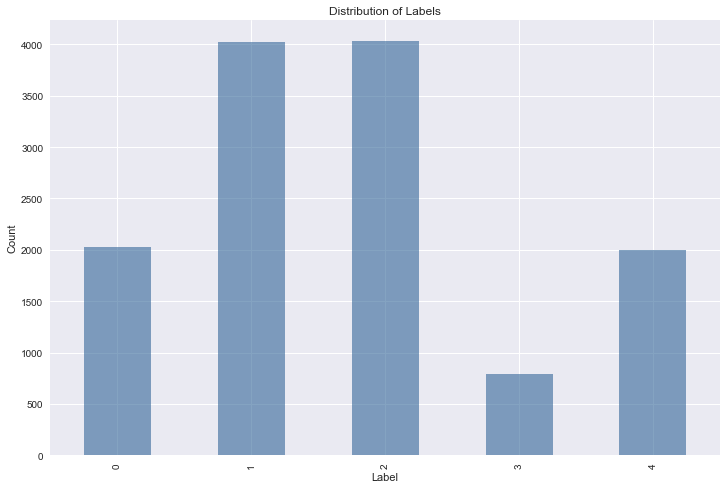

In [45]:
# Plot distribution of rating
print("0 for no label")
print("1 for natural disasters")
print("2 for disease outbreaks")
print("3 for terror attacks")
print("4 for extreme weather")
plt.figure(figsize=(12,8))
df['Category'].value_counts().sort_index().plot(kind='bar', color=(0.2, 0.4, 0.6, 0.6))
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

### Prepare Data

### Train Test Split 

In [5]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Tweets'], df['Category'], test_size=0.2, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(len(X_train),len(X_test)))


Load 10304 training examples and 2577 validation examples. 



In [6]:
y_train

12791    3
5921     2
11930    0
206      1
9674     2
1603     1
11097    0
5147     2
7989     1
11398    0
11190    0
4413     2
920      1
6754     1
7943     1
5770     2
2817     4
10611    0
9603     2
7950     1
2506     4
12327    3
11826    0
7473     1
818      1
7897     1
8753     2
9550     2
7636     1
5194     2
        ..
7599     1
1871     1
2046     4
7877     1
4851     2
5072     2
2163     4
6036     1
6921     1
6216     1
11085    0
537      1
9893     2
2897     4
7768     1
2222     4
10327    0
2599     4
705      1
3468     4
6744     1
5874     2
4373     2
7891     1
9225     2
4859     2
3264     4
9845     2
10799    0
2732     4
Name: Category, Length: 10304, dtype: int64

---
<a id="part3"></a>
## Part 3. Bag of Words

### Text Preprocessing

In [7]:
def cleanText(raw_text, remove_stopwords=True, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'html.parser').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [8]:
X_train[6174]

'#lmswageer Renewed Calls for Early-Warning System After Quake: California quake leads to renewed call... http://t.co/vJ34n3GoYQ #SIGUEME'

In [9]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []
text = 'renewed call for early warning system after quake california quake lead to renewed call'
for d in X_train:
    try:
        X_train_cleaned.append(cleanText(d))
    except:
        X_train_cleaned.append(text)
print('Show a cleaned Tweet in the training set : \n',  X_train_cleaned[0])
for d in X_test:
    X_test_cleaned.append(cleanText(d))
X_train_cleaned

Show a cleaned Tweet in the training set : 
 b rt ramalaneisa guy came know early terrorattack prayersforsrilanka ramanayaker https co gkg l nxh


['b rt ramalaneisa guy came know early terrorattack prayersforsrilanka ramanayaker https co gkg l nxh',
 'warris dis naaa adeola cule cc tweep think symptoms ebola vectorisback',
 'khani yep think world safer place organized crazyness people seeking u coz crazy',
 'rt grasswire photo people walk new island emerged arabian sea minutes pakistan earthquake http co',
 'mobiletechnology questions deadly middle eastern virus showed indiana http co zrf zz',
 'rt auradil india pakistan amankalora enough said',
 'aww thanks bekahpretzel followers follow bekkahpretzel like freakin love',
 'fm hse says woman taken mater hospital morning symptoms ebola virus thank fuck stupid bitch',
 'quake california wine country injures dozens',
 'thomasfiss excited see store next support',
 'haha saw word tweedback first time today like',
 'rt ebolafacts ebolasymptoms stomach pain lack appetite learn signs ebola http co v dt h idc http',
 'usgs reports earthquake km ene borrego springs california utc http co r

### CountVectorizer with Multinomial Naive Bayes (Benchmark Model)

In [10]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 23880 

Show some feature names : 
 ['aa', 'arau', 'bjpagainstacb', 'certificates', 'creation', 'dlmglrl', 'epxni', 'forgetting', 'gurucmath', 'ians', 'jeez', 'kpkoe', 'lvwahod', 'morninglistening', 'notinthescript', 'paper', 'prolusion', 'releif', 'scrappy', 'spreadtheword', 'thank', 'ujztkagytk', 'wallah', 'xq']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n",metrics.confusion_matrix(y_test, predictions) )

In [12]:
def modelTrainEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on train set: {:.4f}".format(accuracy_score(y_train, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_train, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_train, predictions))
    print("\nConfusion Matrix : \n",metrics.confusion_matrix(y_train, predictions) )

In [13]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,predictions)
print('Confusion Matrix : \n', cm1)

0.9503298409002716
Confusion Matrix : 
 [[375  12  20   2   5]
 [  1 753   0   0   1]
 [  8   0 831   0   1]
 [  0   0   0 174   0]
 [ 40  21  17   0 316]]


### TfidfVectorizer with Logistic Regression

In [14]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer() #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 23880 

Show some feature names : 
 ['aa', 'arau', 'bjpagainstacb', 'certificates', 'creation', 'dlmglrl', 'epxni', 'forgetting', 'gurucmath', 'ians', 'jeez', 'kpkoe', 'lvwahod', 'morninglistening', 'notinthescript', 'paper', 'prolusion', 'releif', 'scrappy', 'spreadtheword', 'thank', 'ujztkagytk', 'wallah', 'xq']


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['co' 'rt' 'earthquake' 'http' 'ebola' 'mers' 'pakistan' 'disease' 'india'
 'california']

Top 10 features with largest coefficients : 
['com' 'thanks' 'good' 'day' 'love' 'bit' 'back' 'yeah' 'see' 'oh']


In [16]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
print(accuracy_score(y_test, predictions))
cm1 = confusion_matrix(y_test,predictions)
print('Confusion Matrix : \n', cm1)

0.9642995731470703
Confusion Matrix : 
 [[411   0   0   0   3]
 [  5 750   0   0   0]
 [ 11   0 829   0   0]
 [  1   0   0 173   0]
 [ 62   7   3   0 322]]


### Pipeline and GridSearch

In [17]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
print(accuracy_score(y_test, predictions))
cm1 = confusion_matrix(y_test,predictions)
print('Confusion Matrix : \n', cm1)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
0.9736127279782693
Confusion Matrix : 
 [[402   0   1   0  11]
 [  4 750   0   0   1]
 [  6   0 834   0   0]
 [  0   0   0 174   0]
 [ 43   2   0   0 349]]


In [18]:
#best model - store it
import pickle
filename = 'final.pkl'
pickle.dump(grid, open(filename, 'wb'))

---
<a id="part4"></a>
## Part 4. Word2Vec

### Parsing Review into Sentences

In [19]:
# Split review text into parsed sentences uisng NLTK's punkt tokenizer
# nltk.download()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences


# Parse each tweet in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)
    
print('%d parsed sentence in the training set\n'  %len(sentences))
print('Show a parsed sentence in the training set : \n',  sentences[10])

10303 parsed sentence in the training set

Show a parsed sentence in the training set : 
 ['haha', 'saw', 'word', 'tweedback', 'first', 'time', 'today', 'like']


### Creating Volcabulary List usinhg Word2Vec Model

In [20]:
# Fit parsed sentences to Word2Vec model 
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',level=logging.INFO)

num_features = 300  #embedding dimension                     
min_word_count = 10                
num_workers = 4       
context = 10                                                                                          
downsampling = 1e-3 

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,\
                 window = context, sample = downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context") #save trained word2vec model

print("Number of words in the vocabulary list : %d \n" %len(w2v.wv.index2word)) #4016 
print("Show first 10 words in the vocalbulary list  vocabulary list: \n", w2v.wv.index2word[0:10])

Training Word2Vec model ...

Number of words in the vocabulary list : 1573 

Show first 10 words in the vocalbulary list  vocabulary list: 
 ['co', 'http', 'rt', 'earthquake', 'ebola', 'mers', 'disease', 'india', 'california', 'x']


### Random Forest Classifer

In [46]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_countVect, y_train)
X_test_countVect = countVect.transform(X_test_cleaned)
predictions = rf.predict(X_test_countVect)
print(accuracy_score(y_test, predictions))
cm1 = confusion_matrix(y_test,predictions)
print('Confusion Matrix : \n', cm1)

0.9786573535118355
Confusion Matrix : 
 [[409   0   1   0   4]
 [  1 752   0   0   2]
 [  3   1 835   0   1]
 [  0   0   0 174   0]
 [ 40   2   0   0 352]]


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [39]:
from wordcloud import WordCloud
def create_word_cloud(sentiment):
    
        #df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df.sample(frac=0.01)
        word_cloud_collection = ''
        
        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Category"]==0]["Tweets"]
            
        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Category"]==1]["Tweets"]
        if sentiment == 2:
            df_reviews = df_brand_sample[df_brand_sample["Category"]==2]["Tweets"]
        if sentiment == 3:
            df_reviews = df_brand_sample[df_brand_sample["Category"]==3]["Tweets"]
        if sentiment == 4:
            df_reviews = df_brand_sample[df_brand_sample["Category"]==4]["Tweets"]

        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english') and word != "br"]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    
        

ModuleNotFoundError: No module named 'wordcloud'

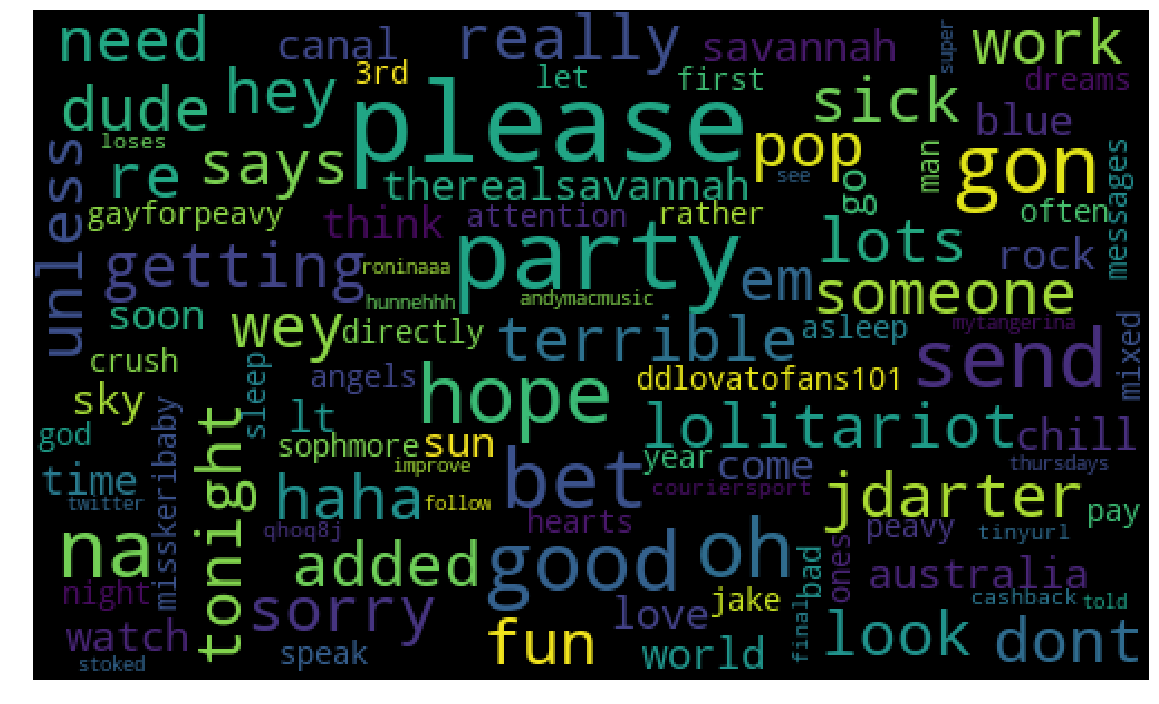

In [32]:
create_word_cloud(sentiment=0)

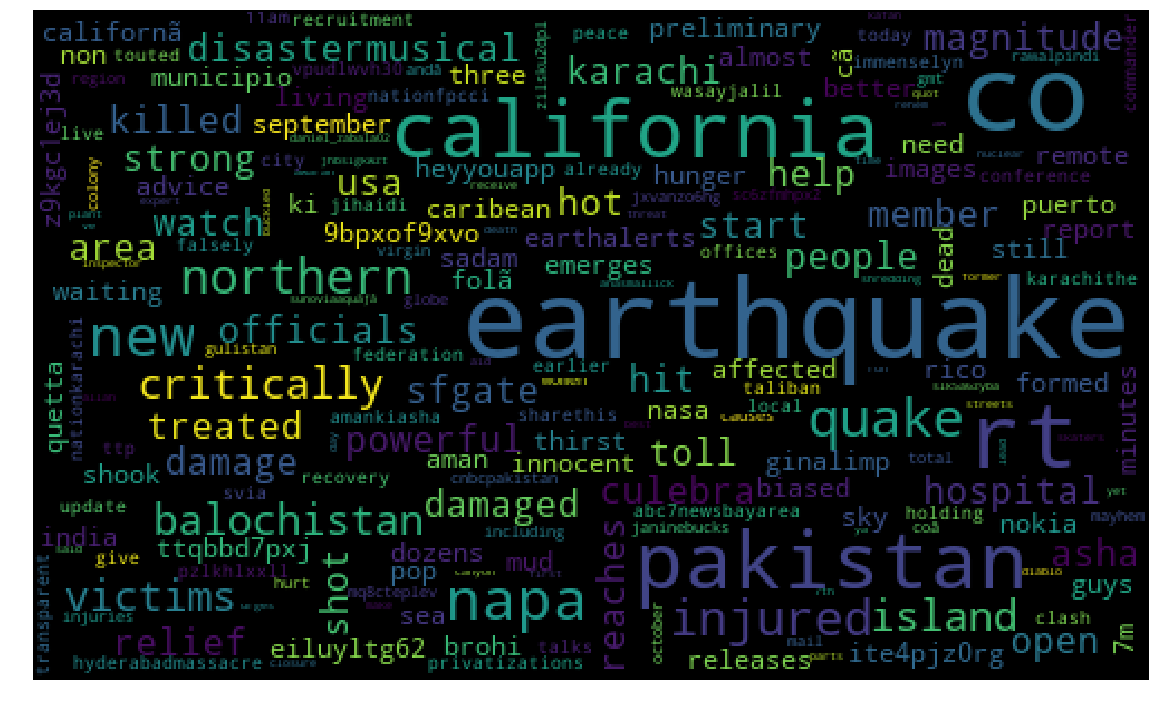

In [33]:
create_word_cloud(sentiment=1)

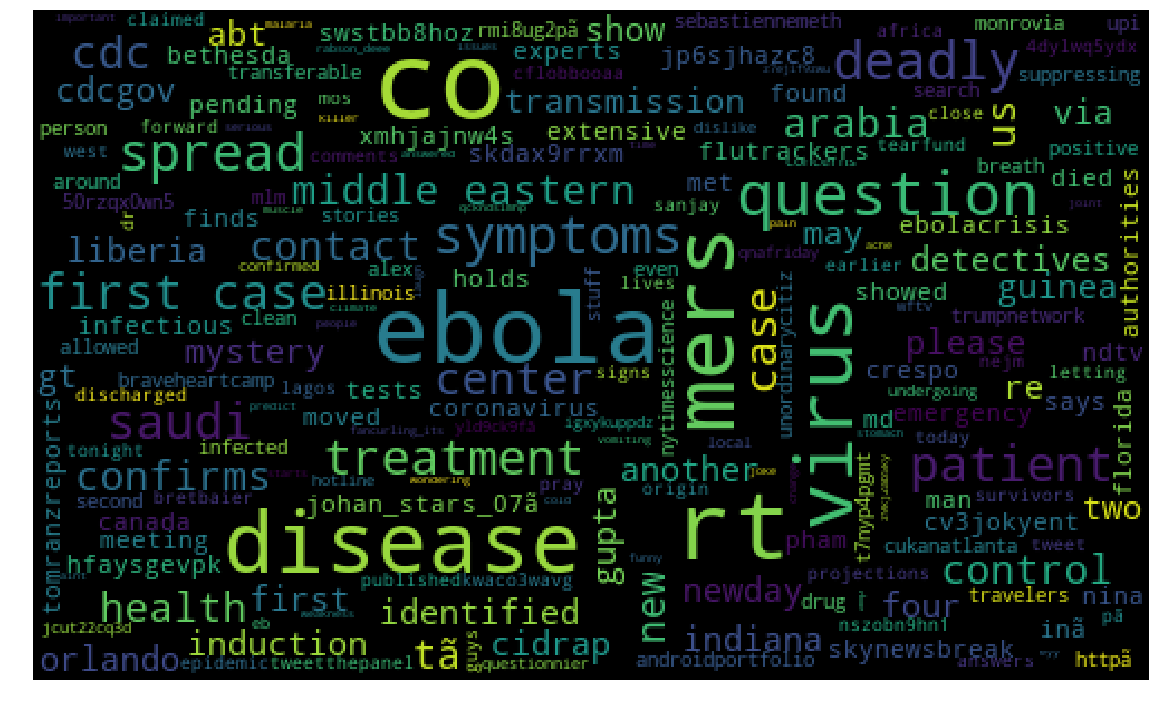

In [34]:
create_word_cloud(sentiment=2)

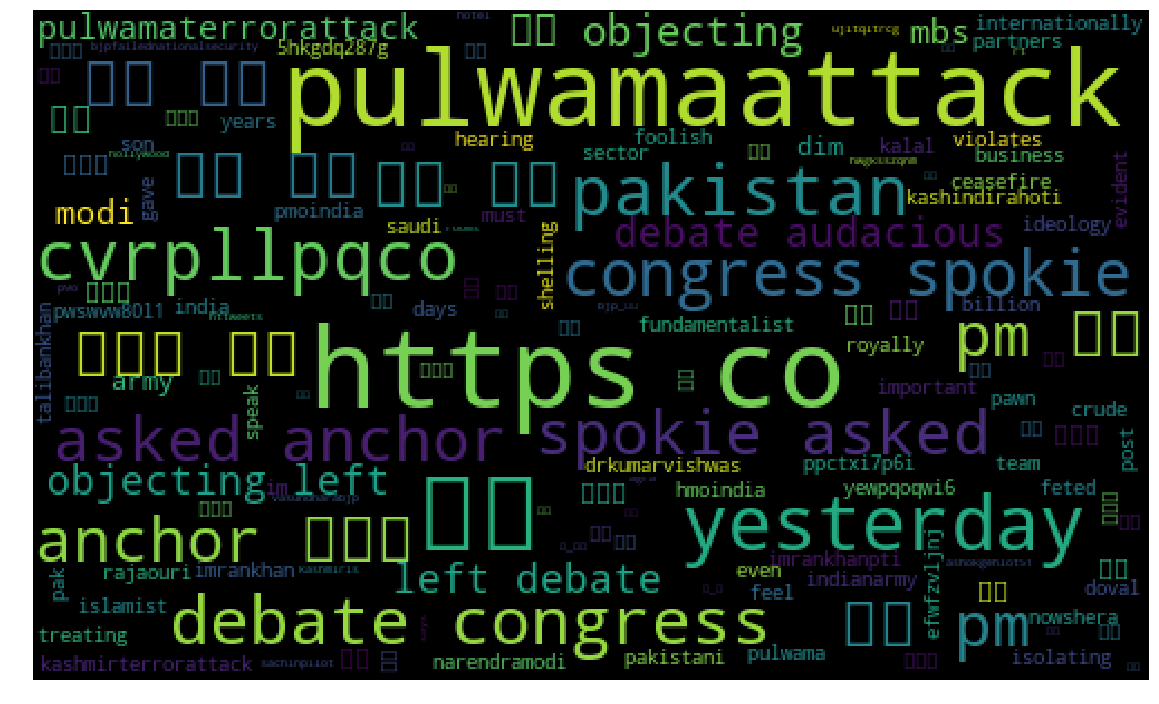

In [35]:
create_word_cloud(sentiment=3)

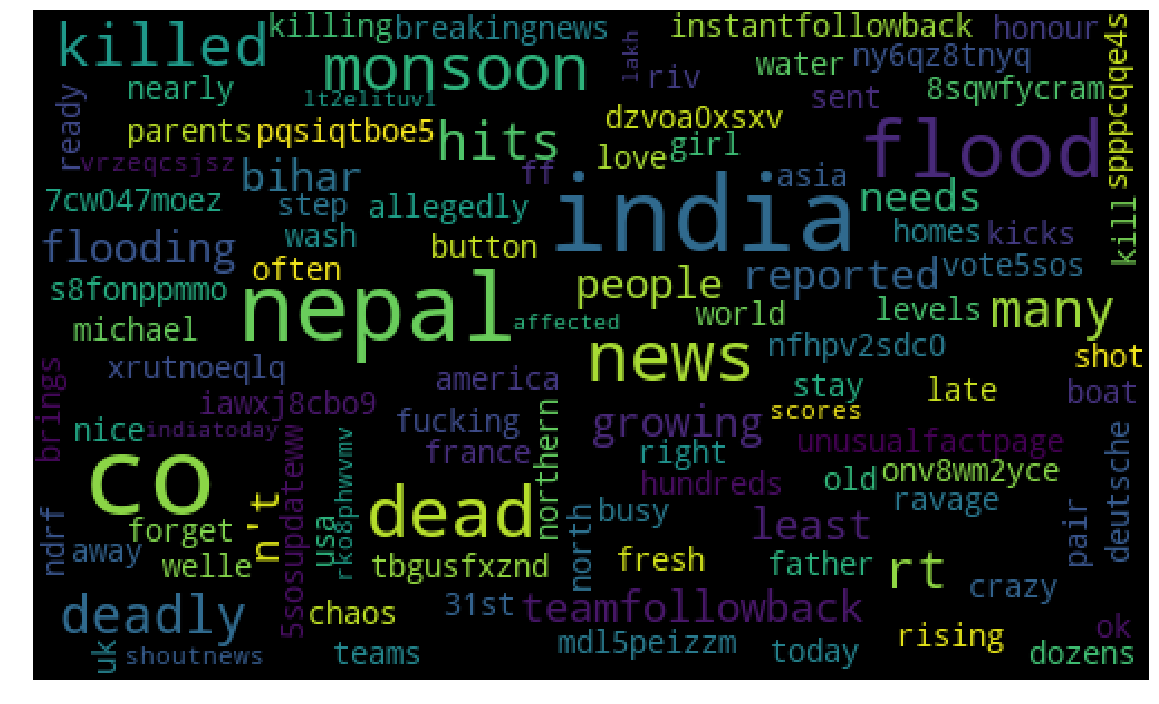

In [36]:
create_word_cloud(sentiment=4)

In [23]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

In [25]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(X_train_cleaned) # only fit on train
tokenize.fit_on_texts(X_test_cleaned) # only fit on train

x_train = tokenize.texts_to_matrix(X_train_cleaned)
x_test = tokenize.texts_to_matrix(X_test_cleaned)

encoder = LabelEncoder()
encoder.fit(X_train_cleaned)
encoder.fit(X_test_cleaned)

num_classes = np.max(y_train)+1 
print(num_classes)
Y_train = utils.to_categorical(y_train, num_classes)
Y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 100

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
verbose=1,
                    validation_split=0.2)

5
Train on 8243 samples, validate on 2061 samples
Epoch 1/100
8243/8243 [==============================] - 9s 1ms/step - loss: 0.3574 - acc: 0.9019 - val_loss: 0.1144 - val_acc: 0.9694
Epoch 2/100
8243/8243 [==============================] - 8s 954us/step - loss: 0.0728 - acc: 0.9808 - val_loss: 0.0916 - val_acc: 0.9709
Epoch 3/100
8243/8243 [==============================] - 7s 892us/step - loss: 0.0491 - acc: 0.9850 - val_loss: 0.0884 - val_acc: 0.9723
Epoch 4/100
8243/8243 [==============================] - 8s 964us/step - loss: 0.0381 - acc: 0.9877 - val_loss: 0.0893 - val_acc: 0.9728
Epoch 5/100
8243/8243 [==============================] - 8s 985us/step - loss: 0.0293 - acc: 0.9905 - val_loss: 0.0938 - val_acc: 0.9704
Epoch 6/100
8243/8243 [==============================] - 7s 897us/step - loss: 0.0233 - acc: 0.9934 - val_loss: 0.1026 - val_acc: 0.9680
Epoch 7/100
8243/8243 [==============================] - 7s 812us/step - loss: 0.0201 - acc: 0.9939 - val_loss: 0.1056 - val_acc: 

8243/8243 [==============================] - 7s 794us/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.2443 - val_acc: 0.9675
Epoch 61/100
8243/8243 [==============================] - 6s 781us/step - loss: 0.0058 - acc: 0.9979 - val_loss: 0.2470 - val_acc: 0.9689
Epoch 62/100
8243/8243 [==============================] - 6s 787us/step - loss: 0.0062 - acc: 0.9978 - val_loss: 0.2504 - val_acc: 0.9675
Epoch 63/100
8243/8243 [==============================] - 6s 767us/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.2513 - val_acc: 0.9665
Epoch 64/100
8243/8243 [==============================] - 7s 789us/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.2499 - val_acc: 0.9685
Epoch 65/100
8243/8243 [==============================] - 7s 835us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.2504 - val_acc: 0.9675
Epoch 66/100
8243/8243 [==============================] - 7s 831us/step - loss: 0.0063 - acc: 0.9979 - val_loss: 0.2503 - val_acc: 0.9675
Epoch 67/100
8243/8243 [=======================

In [26]:
score = model.evaluate(x_test, Y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2577/2577 [==============================] - 0s 122us/step
Test accuracy: 0.9627473806752037


In [27]:
preds = model.predict_classes(x_test)
print(accuracy_score(y_test, preds))
cm1 = confusion_matrix(y_test,list(preds))
print('Confusion Matrix : \n', cm1)

2577/2577 [==============================] - 0s 126us/step
0.9627473806752037
Confusion Matrix : 
 [[373   1   3   0  37]
 [  5 743   1   0   6]
 [  3   0 834   0   3]
 [  1   0   0 173   0]
 [ 34   2   0   0 358]]


In [28]:
#testing

df2 = pd.read_csv('test_data.csv')
cleaned = []
text = 'renewed call for early warning system after quake california quake lead to renewed call'
for d in df2['text']:
    try:
        cleaned.append(cleanText(d))
    except:
        cleaned.append(text)
print('Show a cleaned Tweet in the training set : \n',  cleaned[2])

Show a cleaned Tweet in the training set : 
 heard earthquake different cities stay safe everyone


In [29]:
tfidf = TfidfVectorizer() #minimum document frequency of 5
X_tfidf = tfidf.fit_transform(cleaned)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])


Number of features : 8150 

Show some feature names : 
 ['aa', 'cantstoplaughing', 'eatb', 'hayes', 'liked', 'optimistic', 'rrod', 'tithenai', 'york']


In [30]:
final_model = pickle.load(open(filename, 'rb'))
label = final_model.predict(cleaned)
df2['Category'] = label
df2.to_csv('test_data2.csv')
df2.tail(25)


,text,Category
1975,2.0 #Earthquake in Sicily Italy #iPhone users ...,1
1976,Posted a new song: 'Earthquake' http://t.co/Rf...,1
1977,Some of the aftershocks can be just as big as ...,1
1978,#Sismo ML 2.4 NEAR THE COAST OF WESTERN TURKE...,1
1979,USGS EQ: M 1.9 - 5km S of Volcano Hawaii: Time...,1
1980,Raffi_RC: RT SustainOurEarth: Oklahoma Acts to...,1
1981,#SCSeEstaPreparando Light mag. 4.4 earthquake ...,1
1982,#Earthquake of M 2.9 - 140km W of Ferndale Cal...,1
1983,Nepal earthquake 3 months on: Women fear abuse...,1
1984,#Children traumatised after the Nepal earthqua...,1


In [43]:
test = pd.DataFrame()
x = []
for i in range(len(df2)):
    if(df2['Category'][i] == 0):
        x.append(df2['text'][i])
        print(df2['text'][i])
test['text'] = x
test.to_csv('label0.csv')

Just happened a terrible car crash
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Typhoon Soudelor kills 28 in China and Taiwan
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 
Damage to school bus on 80 in multi car crash #BREAKING 
Hey! How are you?
What's up man?
I love fruits
Summer is lovely
My car is so fast
What a nice hat?
What a goooooooaaaaaal!!!!!!
No I don't like cold!
this is ridiculous....
London is cool ;)
Love skiing
What a wonderful day!
NOOOOOOOOO! Don't do that!
LOOOOOOL
No way...I can't eat that shit
Was in NYC last week!
Love my girlfriend
Cooool :)
Do you like pasta?
No don't tell me that!
What if?

CLEARED: COLLISION: #QEW Fort Erie bound approaching Hwy 405 #Niagara.Vehicles removed. ^ag
Just bought another @meinlcymbals 18' medium crash!! Hey @meinlcymbals what about an endorsement! Starting to get expensive!
Mom fights to recover in hospital from fiery car crash while kids miss her at home - http://t.co/0UH26R2zfX
@SterlingKnight  Who had a car crashsterling!Who was driving in the carMel or JoeySterling Knight???????
@daewony0406 alright now I'm gonna crash I'm so exhausted
#INCIDENT

Crash in Pascoe Vale South outbound on Tullamarine Fwy (CityLink) near Moreland Rd. Vehicles off in emergency lane. No delays.
I let another love crash and burn
If you sit and rant on snapchat to your apparent fans when you have about 8000 followers I hope your in a train crash xoxo
#portmoody Clarke Rd hill n/b blocked by crash past Seaview traffic back to Kemsley. Take Como Lake to Gatensbury to get around it.
@spicybreads @coxytown i tried downloading it and it crashed after the tutorial
My so

In [42]:
test = pd.DataFrame()
x = []
for i in range(len(df2)):
    if(df2['Category'][i] == 1):
        x.append(df2['text'][i])
        print(df2['text'][i])
test['text'] = x
test.to_csv('label1.csv')

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Heard about #earthquake is different cities, stay safe everyone.
13,000 people receive #wildfires evacuation orders in California 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
We're shaking...It's an earthquake
Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA
How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr
How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd
@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680
#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM
#TruckCrash Overtur

In [41]:
test = pd.DataFrame()
x = []
for i in range(len(df2)):
    if(df2['Category'][i] == 2):
        x.append(df2['text'][i])
        print(df2['text'][i])
test['text'] = x
test.to_csv('label2.csv')

Barbados #Bridgetown JAMAICA – Two cars set ablaze: SANTA CRUZ — Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Progressive greetings!



In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt
Accident center lane blocked in #SantaClara on US-101 NB before Great America Pkwy #BayArea #Traffic http://t.co/pmlOhZuRWR
On the #M42 northbound between junctions J3 and J3A there are currently delays of 10 mins due to an accident c... http://t.co/LwI3prBa31
Aftershock: Protect Yourself and Profit in the Next Global Financial Meltdown by David Wiedemer http http://t.co/WZTz4hgMVq
&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z

@esquireattire
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn... http://t.co/bKpFpOGySI
Man Goes into Airplane Engine Accident: http://t.co/TYJxrFd3St via @You

In [40]:
test = pd.DataFrame()
x = []
for i in range(len(df2)):
    if(df2['Category'][i] == 3):
        x.append(df2['text'][i])
        print(df2['text'][i])
test['text'] = x
test.to_csv('label3.csv')

Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z
Suffield Alberta Accident https://t.co/bPTmlF4P10
Praise God that we have ministry that tells it like it is!!! #now #wdyouth #biblestudy https://t.co/UjK0e5GBcC
airplane crashes on house in Colombia 12 people die in accident https://t.co/ZhJlfLBHZL
((OFFICIAL VID)) #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Prod @THISIZBWRIGHT &gt;&gt; #ARMAGEDDON
**OFFICIAL VID** #TheReal &gt;&gt;&gt; https://t.co/4i0Rjc9RQU &gt;&gt;&gt; @TrubGME &gt;&gt;&gt; #ARMAGEDDON Comin Soon!!
960KZIM: Steele police arrest 2 in possible arson investigation https://t.co/w6ZbWryqjC
I'm feeling so attacked https://t.co/CvkQiGr1AZ
https://t.co/WKv8VqVkT6 #ArtisteOfTheWeekFact say #Conversations by #coast2coastdjs agree @Crystal_Blaz 's #Jiwonle is a #HipHop #ClubBanger
My ears are bleeding  https://t.co/k5KnNwugwT
*Ears bleeding from the bass* https://t.co/d5RrrwHjpN
I'm over here listening to Bloo

In [44]:
test = pd.DataFrame()
x = []
for i in range(len(df2)):
    if(df2['Category'][i] == 4):
        x.append(df2['text'][i])
        print(df2['text'][i])
test['text'] = x
test.to_csv('label4.csv')

#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
#PreviouslyOnDoyinTv: Toke Makinwa’s marriage crisis sets Nigerian Twitter ablaze... http://t.co/CMghxBa2XI
I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6
Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
Police: Arsonist Deliberately Set Black Church In North Carolina Ablaze http://t.co/pcXarbH9An
TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF
Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @… https://t.co/cYoMPZ1A0Z
SETTING MYSELF ABLAZE http://t.co/6vMe7P5XhC
#nowplaying Alfons - Ablaze 2015 on Puls Radio #pulsradio http://t.co/aA5BJgWfDv
@nxwestmidlands huge fire at Wholesale markets ablaze http://t.co/rwzbFVNXER
Please like and share our new page for

In [36]:
#display to the user
print("Top 10 tweets for label 1: natural disaster")
count = 0
for i in range(len(df2)):
    if count < 11:
        if(df2['Category'][i] == 1):
            print(df2['text'][i])
            count = count + 1

Top 10 tweets for label 1: natural disaster
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Heard about #earthquake is different cities, stay safe everyone.
13,000 people receive #wildfires evacuation orders in California 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
We're shaking...It's an earthquake
Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birmingham's Wholesale Market http://t.co/irWqCEZWEU
INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA
How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr
How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd
@Navista7 Steve these fires out here are something else! California is a tinderbox - and this clown was setting my 'hood ablaze @News24680
#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http

In [37]:
#display to the user
print("Top 10 tweets for label 2: disease outbreaks")
count = 0
for i in range(len(df2)):
    if count < 11:
        if(df2['Category'][i] == 2):
            print(df2['text'][i])
            count = count + 1

Top 10 tweets for label 2: disease outbreaks
Barbados #Bridgetown JAMAICA – Two cars set ablaze: SANTA CRUZ — Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Progressive greetings!



In about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt
Accident center lane blocked in #SantaClara on US-101 NB before Great America Pkwy #BayArea #Traffic http://t.co/pmlOhZuRWR
On the #M42 northbound between junctions J3 and J3A there are currently delays of 10 mins due to an accident c... http://t.co/LwI3prBa31
Aftershock: Protect Yourself and Profit in the Next Global Financial Meltdown by David Wiedemer http http://t.co/WZTz4hgMVq
&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z

@esquireattire
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on Wedn... http://t.co/bKpFpOGySI
Man Goes into Airplane Eng

In [55]:
#display to the user
print("Top 10 tweets for label 3: terror attacks")
count = 0
for i in range(len(df2)):
    if count < 11:
        if(df2['Category'][i] == 3):
            print(df2['text'][i])
            count = count + 1

Top 10 tweets for label 3: terror attacks
Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @… https://t.co/cYoMPZ1A0Z
Rene Ablaze &amp; Jacinta - Secret 2k13 (Fallen Skies Edit) - Mar 30 2013  https://t.co/7MLMsUzV1Z
Accident on I-24 W #NashvilleTraffic. Traffic moving 8m slower than usual. https://t.co/0GHk693EgJ
Suffield Alberta Accident https://t.co/bPTmlF4P10
Praise God that we have ministry that tells it like it is!!! #now #wdyouth #biblestudy https://t.co/UjK0e5GBcC
This is unbelievably insane.

#man #airport #airplane #aircraft #aeroplane #runway #accident #freaky… https://t.co/cezhq7CzLl
Pilot Dies In Plane Crash At Car Festival https://t.co/kQ9aE6AP2B via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest
airplane crashes on house in Colombia 12 people die in accident https://t.co/ZhJlfLBHZL
The shooting or the airplane accident  https://t.co/iECc1JDOub
U.S National Park Services Tonto National Forest: Stop the A

In [38]:
#display to the user
print("Top 10 tweets for label 4: extreme weather")
count = 0
for i in range(len(df2)):
    if count < 11:
        if(df2['Category'][i] == 4):
            print(df2['text'][i])
            count = count + 1

Top 10 tweets for label 4: extreme weather
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw
#PreviouslyOnDoyinTv: Toke Makinwa’s marriage crisis sets Nigerian Twitter ablaze... http://t.co/CMghxBa2XI
I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6
Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
Police: Arsonist Deliberately Set Black Church In North Carolina Ablaze http://t.co/pcXarbH9An
TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE OR TAMBO INTL. CARGO SECTION. http://t.co/8kscqKfKkF
Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @… https://t.co/cYoMPZ1A0Z
SETTING MYSELF ABLAZE http://t.co/6vMe7P5XhC
#nowplaying Alfons - Ablaze 2015 on Puls Radio #pulsradio http://t.co/aA5BJgWfDv
@nxwestmidlands huge fire at Wholesale markets ablaze http://t.co/rwzbFV